# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

[Q1] Two-proportion z-test p-value: 0.963933
[Q2] Chi-square (num_effects ~ trx) p-value: 0.615012


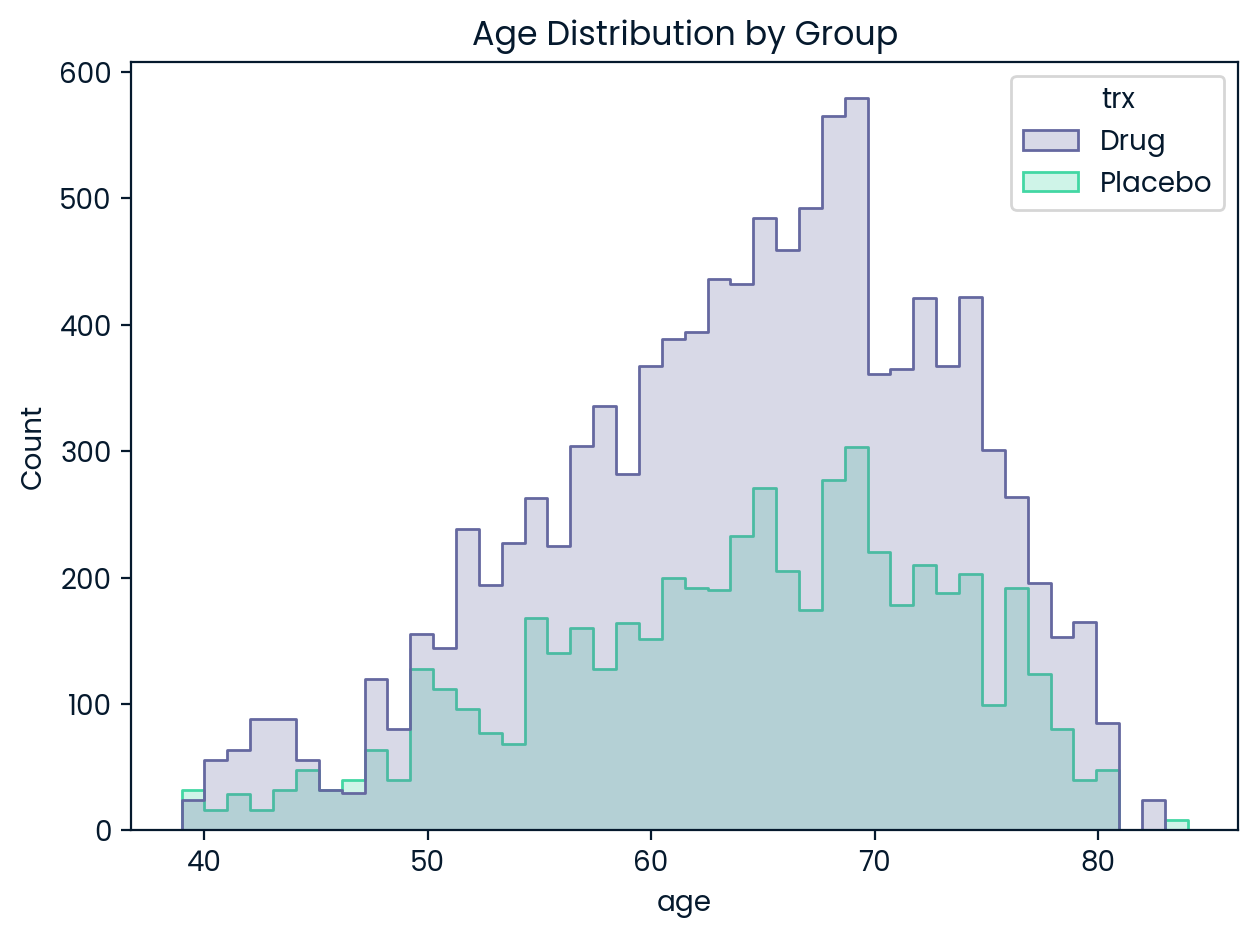

[Q3] Welch t-test (age) p-value: 0.140314


<Figure size 640x480 with 0 Axes>

In [53]:
# Imports
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load & basic cleanup ---
drug_safety = pd.read_csv("drug_safety.csv")
drug_safety["trx"] = drug_safety["trx"].astype(str).str.strip()
drug_safety["adverse_effects"] = drug_safety["adverse_effects"].astype(str).str.strip()

# --- Q1: Difference in proportion with at least one adverse effect (Drug vs Placebo) ---
# Encode binary outcome
drug_safety["adverse_effects_binary"] = drug_safety["adverse_effects"].map({"No": 0, "Yes": 1})

# counts = number with AE per group; nobs = total per group
counts = (
    drug_safety.groupby("trx", dropna=False)["adverse_effects_binary"]
    .sum()
    .to_numpy()
)
nobs = (
    drug_safety.groupby("trx", dropna=False)["adverse_effects_binary"]
    .count()
    .to_numpy()
)

# Two-proportion z-test
_, two_sample_p_value = proportions_ztest(count=counts, nobs=nobs)

print(f"[Q1] Two-proportion z-test p-value: {two_sample_p_value:.6g}")

# --- Q2: Independence between NUM of adverse effects and group ---
# Chi-square test of independence on contingency table (num_effects x trx)
# (pingouin handles building the table internally)
chi2_tables = pg.chi2_independence(data=drug_safety, x="num_effects", y="trx")
num_effects_p_value = chi2_tables[2]["pval"][0]

print(f"[Q2] Chi-square (num_effects ~ trx) p-value: {num_effects_p_value:.6g}")

# --- Plot ---
sns.histplot(data=drug_safety, x="age", hue="trx", element="step", stat="count")
plt.title("Age Distribution by Group")
plt.tight_layout()
plt.show()
plt.savefig("Age_distribution.png")

# --- Q3: Difference in AGE between Drug vs Placebo ---
drug_ages = drug_safety.loc[drug_safety["trx"] == "Drug", "age"].dropna()
placebo_ages = drug_safety.loc[drug_safety["trx"] == "Placebo", "age"].dropna()

# Welch's two-sample t-test (does not assume equal variances)
_, age_p_value = ttest_ind(drug_ages, placebo_ages, equal_var=False)
print(f"[Q3] Welch t-test (age) p-value: {age_p_value:.6g}")

# If your assignment wants Mann–Whitney instead, replace the line above with:
# age_p_value = pg.mwu(drug_ages, placebo_ages)["p-val"].iat[0]
